# **Important Libraries**

In [ ]:
!pip install lz4

In [ ]:
!pip install mtcnn

In [3]:
!pip install streamlit pyngrok opencv-python-headless --quiet

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from PIL import Image, ImageTk
from tqdm import tqdm
from collections import Counter
from mtcnn import MTCNN
# import lz4

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from skimage.feature import hog

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from pyngrok import ngrok
import subprocess
import time
import streamlit as st
import urllib.request

2025-05-06 12:52:00.536454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746535920.560270     124 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746535920.567282     124 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Dataset Paths**

In [2]:
# Define dataset paths
base_path = '/kaggle/input/fer2013'
train_path = os.path.join(base_path, 'train') # Training path
test_path = os.path.join(base_path, 'test') # Testing path

print("Training data:\n")
for folder in os.listdir(train_path):
    print(f"{folder}: {len(os.listdir(os.path.join(train_path, folder)))} images")

print("\n"+"="*25)

print("\nTesting data:\n")
for folder in os.listdir(test_path):
    print(f"{folder}: {len(os.listdir(os.path.join(test_path, folder)))} images")

Training data:

surprise: 3171 images
fear: 4097 images
angry: 3995 images
neutral: 4965 images
sad: 4830 images
disgust: 436 images
happy: 7215 images


Testing data:

surprise: 831 images
fear: 1024 images
angry: 958 images
neutral: 1233 images
sad: 1247 images
disgust: 111 images
happy: 1774 images


# **Image Preprocessing**

In [4]:
# Image Preprocessing
def preprocess_fer2013(img, expand_dims=True):
    
    img = img.astype(np.uint8)

    # Noise Reduction (should be done before the Contrast Adjustment)
    img = cv2.fastNlMeansDenoising( # Fast - Non-local Means Denoising
        img, None,
        h=7,   # Filter strength (5-10) (higher = more denoising) Higher values remove more noise but may lose some details
        templateWindowSize=5, # Size of the patch used to compare similarity (5x5 pixels) | Larger patches capture more structural information but are computationally expensive
        searchWindowSize=15   # Region area around each pixel where similar patches are searched (15x15 pixels) | Larger windows find more similar patches but increase computation time
    )

    # Contrast Limited Adjustment Histogram Equalization (CLAHE) -> Can help make facial features more distinguishable (improves contrast locally)
    clahe = cv2.createCLAHE(
        clipLimit=2.0, # clipLimit : Limits the amplification of contrast to prevent noise over-enhancement.
        tileGridSize=(8, 8) # Divides the image into an 8x8 grid of tiles (64 tiles total). CLAHE processes each tile independently.
    )
    img = clahe.apply(img)

    # Combines the original and blurred image to enhance edges
    blurred = cv2.GaussianBlur( # Apply Gaussian Blurring on the image
        img, # input image
        (3, 3), # kernel 3 x 3
        1.0 # Sigma of the Gaussian
    )

    # Sharpens the image by subtracting a blurred version (Unsharp Masking)
    img = cv2.addWeighted( # result = (1.2 * original) + (-0.2 * blurred) + 0
        img, # The original image
        1.2, # weight i multiply in the original one
        blurred, # the blurred image after applying Gaussian 
        -0.2, # weight i multiply in the blurred image
        0
    ) 
    
    img = img / 255.0 # Normalization -> Rescale pixel values to [0, 1]
    
    if expand_dims:  # Only expand dimensions in CNN
        img = np.expand_dims(img, axis=-1)
        # Add channel dimension -> Shape: (48, 48, 1) For the input shape of CNN. 1 : For one channel (grayscal)
        # Shape: (48, 48, 3) For RGB image => 3 channels

    return img

In [5]:
# Load data + detect faces first then preprocess
def load_and_preprocess_dataset_mtcnn(base_path, preprocess_fer2013, use_CNN):
    X, y = [], []
    class_names = sorted(os.listdir(base_path))  # Get sorted class folders alphabetically
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

    detector = MTCNN()  # Initialize MTCNN face detector

    for cls_name in class_names:
        cls_path = os.path.join(base_path, cls_name)
        
        for file_name in tqdm(os.listdir(cls_path), desc=f"Loading {cls_name}"):
            file_path = os.path.join(cls_path, file_name)
            img = cv2.imread(file_path)
    
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for MTCNN
            faces = detector.detect_faces(img_rgb)

            # Process all detected faces
            for face in faces:
                x, y1, w, h = face['box']
                x, y1 = max(0, x), max(0, y1)
                cropped_face = img[y1:y1+h, x:x+w]

                # Resize to FER2013 expected size
                resized_face = cv2.resize(cropped_face, (48, 48))
                gray_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)

                # Apply preprocessing
                processed_face = preprocess_fer2013(gray_face, expand_dims=use_CNN)
                X.append(processed_face)
                y.append(class_to_idx[cls_name])

    X = np.array(X)
    y = np.array(y)
    return X, y, class_names

# **Feature Extraction**

The FER2013 dataset contains facial expressions, and this combination works well because:
    
    HOG captures the overall facial structure and important gradients around eyes, mouth, etc.
    

In [6]:
# Feature Extraction 
def extract_hog_features(img): # HOG : Histogram of Oriented Gradients
    
    # 1. Gradient Computation: magnitude & direction for each pixel
    # 2. Orientation Binning (9 bins)
    # 3. Cell Division (8×8 pixels):
        # Divides image into small spatial regions called "cells" (8×8 pixels in this case)
        # Creates a histogram of oriented gradients for each cell
    # 4. Block Normalization (2×2 cells):
        # Groups cells into larger "blocks" (2×2 cells = 16×16 pixels here)
        # Normalizes histograms within each block to make features invariant to illumination changes
        # Uses overlapping blocks for better results (default step size is 1 cell)
    # 5. Feature Vector Formation:
        # Concatenates all normalized block histograms into one long feature vector
        # For a 48×48 image with these parameters: (6 cells × 6 cells × 4 blocks × 9 bins = 1296 features)
    
    features, _ = hog( 
        img,
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2),
        visualize=True
    )
    return features

# **Data Augmentation**


Why this is important (FER2013 dataset)?

FER2013 is imbalanced, with certain emotions like 'Happy' and 'Neutral' having far more images than 'Disgust' or 'Fear'. 
- This function helps:
    1. Balance class distributions.
    2. Improve training stability.
    3. Prevent bias toward overrepresented classes.

In [7]:
# Define augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,           # Randomly rotates the image between –10 to +10 degrees.
    width_shift_range=0.1,       # Shifts the image horizontally by up to 10% of the width.
    height_shift_range=0.1,      # Shifts the image vertically by up to 10% of the height. 
    shear_range=0.1,             # Applies a shearing transformation, slanting the image slightly.
    zoom_range=0.1,              # Randomly zooms in or out by up to 10%.
    horizontal_flip=True,        # Randomly flips the image horizontally (mirror flip).
    fill_mode='nearest',         # Fills in missing pixels after a transformation using the value of the nearest pixel.
    brightness_range=[0.8, 1.2]  # Randomly adjusts brightness 
)

In [8]:
# Function to augment a class to a target number of samples
def augment_class_general(X, y, class_idx, target_samples, class_name, for_cnn=True):
    X_class = X[y == class_idx] # Get only the images belonging to the class we want to augment.
    num_current = len(X_class)
    
    num_to_generate = max(0, target_samples - num_current)  # Ensure non-negative
    if num_to_generate == 0:
        return X_class, np.full(num_current, class_idx)

    print(f"Augmenting {class_name}: {num_current} → {target_samples} (generating {num_to_generate})")

    X_aug, y_aug = [], []

    # Generate augmented images
    for i in tqdm(range(num_to_generate), desc=f"Augmenting {class_name}"):
        
        img = X_class[np.random.randint(0, num_current)] # Random image
        img = img.reshape(1, 48, 48, 1)  # Reshape for ImageDataGenerator
        
        for aug_img in datagen.flow(img, batch_size=1, seed=i):
            X_aug.append(aug_img[0]) # Add the augmented image
            y_aug.append(class_idx) # Label remains the same
            break  # Take one image per iteration

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)

    if not for_cnn:
        # Squeeze to remove the channel dimension if it's 1, e.g., (48, 48, 1) → (48, 48) for SVM
        X_aug = np.squeeze(X_aug)

    X_combined = np.vstack([X_class, X_aug])
    y_combined = np.hstack([np.full(num_current, class_idx), y_aug])

    return X_combined, y_combined

# **Loading Data & Preprocessing it**

In [9]:
# Load and preprocess training dataset [CNN]
X_train_4CNN, y_train_4CNN, class_names = load_and_preprocess_dataset_mtcnn(train_path, preprocess_fer2013, True)

I0000 00:00:1746536010.556458     124 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746536010.557148     124 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Loading surprise: 100%|██████████| 3171/3171 [03:28<00:00, 15.22it/s]


In [10]:
# Load and preprocess test dataset [CNN]
X_test_4CNN, y_test_4CNN, _ = load_and_preprocess_dataset_mtcnn(test_path, preprocess_fer2013, True)

Loading surprise: 100%|██████████| 831/831 [00:55<00:00, 15.09it/s]


In [11]:
# Load and preprocess training dataset [SVM]
X_train_4SVM, y_train_4SVM, class_names = load_and_preprocess_dataset_mtcnn(train_path, preprocess_fer2013, False)

Loading surprise: 100%|██████████| 3171/3171 [03:29<00:00, 15.11it/s]


In [12]:
# Load and preprocess test dataset [SVM]
X_test_4SVM, y_test_4SVM, _ = load_and_preprocess_dataset_mtcnn(test_path, preprocess_fer2013, False) 

Loading surprise: 100%|██████████| 831/831 [00:54<00:00, 15.24it/s]


In [13]:
def show_sample_images(X, y, class_names, samples=10):
    plt.figure(figsize=(15, 5))

    # Randomly select sample indices
    indices = np.random.choice(len(X), size=samples, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(1, samples, i + 1)
        img = X[idx]

        # Display grayscale image if it's 2D
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)

        # Set the title to the corresponding class name
        plt.title(class_names[y[idx]])
        plt.axis('off')  # Hide axis

    plt.tight_layout()  # Adjust spacing
    plt.show()

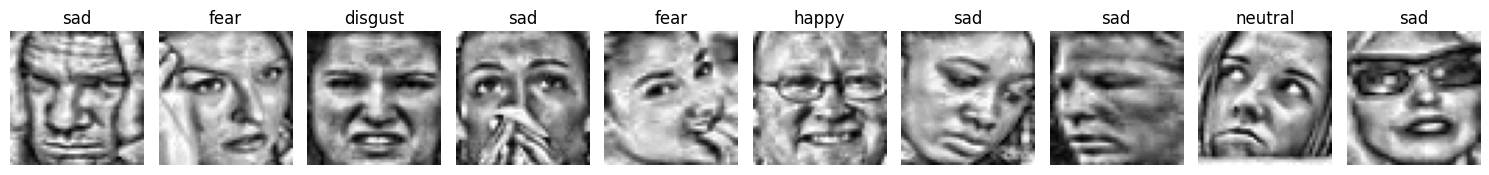

In [14]:
show_sample_images(X_train_4SVM, y_train_4SVM, class_names)

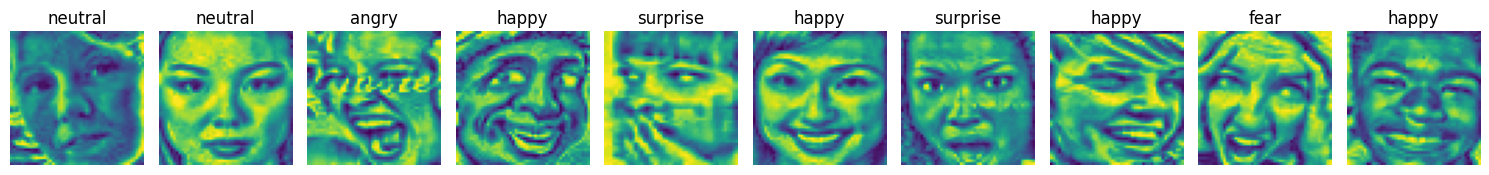

In [15]:
show_sample_images(X_train_4CNN, y_train_4CNN, class_names)

# **Split Training data to [Train & Validation]**

In [16]:
# Split train/validation [CNN]
X_train_4CNN, X_val_4CNN, y_train_4CNN, y_val_4CNN = train_test_split(X_train_4CNN, y_train_4CNN, test_size=0.2, stratify=y_train_4CNN, random_state=42)

In [17]:
# Split train/validation [SVM]
X_train_4SVM, X_val_4SVM, y_train_4SVM, y_val_4SVM = train_test_split(X_train_4SVM, y_train_4SVM, test_size=0.2, stratify=y_train_4SVM, random_state=42)

In [18]:
# Function to nicely print class distributions
def print_class_distribution(y, class_names, dataset_name="Dataset"):
    print(f"\n{dataset_name} class distribution:")
    unique, counts = np.unique(y, return_counts=True)

    for cls, count in zip(unique, counts):
        print(f"{class_names[cls]}: {count} images")

    print(f"Total samples: {len(y)}")

In [19]:
# After splitting [CNN]
print("4CNN\n=====")
print_class_distribution(y_train_4CNN, class_names, dataset_name="Training set")
print_class_distribution(y_val_4CNN, class_names, dataset_name="Validation set")

4CNN
=====

Training set class distribution:
angry: 2681 images
disgust: 262 images
fear: 2595 images
happy: 4999 images
neutral: 3525 images
sad: 2922 images
surprise: 2177 images
Total samples: 19161

Validation set class distribution:
angry: 670 images
disgust: 65 images
fear: 649 images
happy: 1250 images
neutral: 882 images
sad: 731 images
surprise: 544 images
Total samples: 4791


In [20]:
# After splitting [SVM]
print("4SVM\n=====")
print_class_distribution(y_train_4SVM, class_names, dataset_name="Training set")
print_class_distribution(y_val_4SVM, class_names, dataset_name="Validation set")

4SVM
=====

Training set class distribution:
angry: 2681 images
disgust: 262 images
fear: 2595 images
happy: 4999 images
neutral: 3525 images
sad: 2922 images
surprise: 2177 images
Total samples: 19161

Validation set class distribution:
angry: 670 images
disgust: 65 images
fear: 649 images
happy: 1250 images
neutral: 882 images
sad: 731 images
surprise: 544 images
Total samples: 4791


# **Apply Augmentation on Training ONLY , NOT on Validation or Testing**

In [21]:
# Apply Aug for CNN

target_samples = 3500 # The most Suitable number for Our FER2013 data -> gets the most test accuracy
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

X_train_aug_4CNN, y_train_aug_4CNN = [] , []

for class_name, class_idx in class_to_idx.items():
    X_class, y_class = augment_class_general(X_train_4CNN, y_train_4CNN, class_idx, target_samples, class_name, for_cnn=True)
    X_train_aug_4CNN.append(X_class)
    y_train_aug_4CNN.append(y_class)

X_train_aug_4CNN = np.vstack(X_train_aug_4CNN)
y_train_aug_4CNN = np.hstack(y_train_aug_4CNN)

Augmenting angry: 2681 → 3500 (generating 819)


Augmenting angry: 100%|██████████| 819/819 [00:00<00:00, 1817.18it/s]


Augmenting disgust: 262 → 3500 (generating 3238)


Augmenting disgust: 100%|██████████| 3238/3238 [00:01<00:00, 1918.80it/s]


Augmenting fear: 2595 → 3500 (generating 905)


Augmenting fear: 100%|██████████| 905/905 [00:00<00:00, 1969.73it/s]


Augmenting sad: 2922 → 3500 (generating 578)


Augmenting sad: 100%|██████████| 578/578 [00:00<00:00, 2012.04it/s]


Augmenting surprise: 2177 → 3500 (generating 1323)


Augmenting surprise: 100%|██████████| 1323/1323 [00:00<00:00, 1976.65it/s]


In [22]:
# Apply Aug for SVM

target_samples = 3500 # The most Suitable number for Our FER2013 data -> gets the most test accuracy
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

X_train_aug_4SVM, y_train_aug_4SVM = [], []

for class_name, class_idx in class_to_idx.items():
    X_class, y_class = augment_class_general(X_train_4SVM, y_train_4SVM, class_idx, target_samples, class_name, for_cnn=False)
    X_train_aug_4SVM.append(X_class)
    y_train_aug_4SVM.append(y_class)

X_train_aug_4SVM = np.vstack(X_train_aug_4SVM)
y_train_aug_4SVM = np.hstack(y_train_aug_4SVM)

Augmenting angry: 2681 → 3500 (generating 819)


Augmenting angry: 100%|██████████| 819/819 [00:00<00:00, 1955.00it/s]


Augmenting disgust: 262 → 3500 (generating 3238)


Augmenting disgust: 100%|██████████| 3238/3238 [00:01<00:00, 1963.00it/s]


Augmenting fear: 2595 → 3500 (generating 905)


Augmenting fear: 100%|██████████| 905/905 [00:00<00:00, 1980.20it/s]


Augmenting sad: 2922 → 3500 (generating 578)


Augmenting sad: 100%|██████████| 578/578 [00:00<00:00, 1924.89it/s]


Augmenting surprise: 2177 → 3500 (generating 1323)


Augmenting surprise: 100%|██████████| 1323/1323 [00:00<00:00, 1921.51it/s]


# **Apply Exrtract features on every image in the data for SVM model**

- Traditional machine learning models (like SVMs) cannot operate directly on raw image pixels.
- This method extracts compact, informative representations (shape + texture) that models can work with.

In [23]:
# Extract features for train, validation, and test sets
print("Extracting features...")

#Applies extract_features to every image in the training set, storing the results as a 2D NumPy array: Shape: (num_images, num_features_per_image)
X_train_features = np.array([extract_hog_features(img) for img in X_train_aug_4SVM])
X_val_features = np.array([extract_hog_features(img) for img in X_val_4SVM])
X_test_features = np.array([extract_hog_features(img) for img in X_test_4SVM])

# Print shapes for verification
print(f"Training features shape: {X_train_features.shape}")
print(f"Validation features shape: {X_val_features.shape}")
print(f"Test features shape: {X_test_features.shape}")

print(f"Training labels shape: {y_train_aug_4SVM.shape}")
print(f"Validation labels shape: {y_val_4SVM.shape}")
print(f"Test labels shape: {y_test_4SVM.shape}")

Extracting features...
Training features shape: (26024, 900)
Validation features shape: (4791, 900)
Test features shape: (5986, 900)
Training labels shape: (26024,)
Validation labels shape: (4791,)
Test labels shape: (5986,)


# **SVM model**

In [24]:
# SVM Training
print("Training SVM...")
svm = SVC(
    kernel='rbf', # Uses the Radial Basis Function (RBF) kernel, which is a popular choice for SVMs. It can handle non-linear decision boundaries.
    C=1.0, # The regularization parameter. smaller C -> a wider margin (misclassifications),larger C aims to classify all training examples correctly (overfitting).
    probability=True, # enables probability estimates. This makes the SVM slightly slower but enables you to get class probabilities.
    random_state=42
)

svm.fit(X_train_features, y_train_aug_4SVM)

Training SVM...


SVC(probability=True, random_state=42)

In [25]:
# Compute Training Accuracy 
y_train_pred_4SVM = svm.predict(X_train_features)
train_accuracy_4SVM = accuracy_score(y_train_aug_4SVM, y_train_pred_4SVM)

# Validate SVM
y_val_pred_4SVM = svm.predict(X_val_features)
val_accuracy_4SVM = accuracy_score(y_val_4SVM, y_val_pred_4SVM)

# Evaluation on Test Set
y_test_pred_4SVM = svm.predict(X_test_features)
test_accuracy_4SVM = accuracy_score(y_test_4SVM, y_test_pred_4SVM)

precision_4SVM, recall_4SVM, f1_4SVM, _ = precision_recall_fscore_support(y_test_4SVM, y_test_pred_4SVM, average='weighted')

Training Accuracy: 0.6573
Validation Accuracy: 0.5446

Test Set Evaluation:
Test Accuracy: 0.5373
Test Precision: 0.5331
Test Recall: 0.5373
Test F1-Score: 0.5233


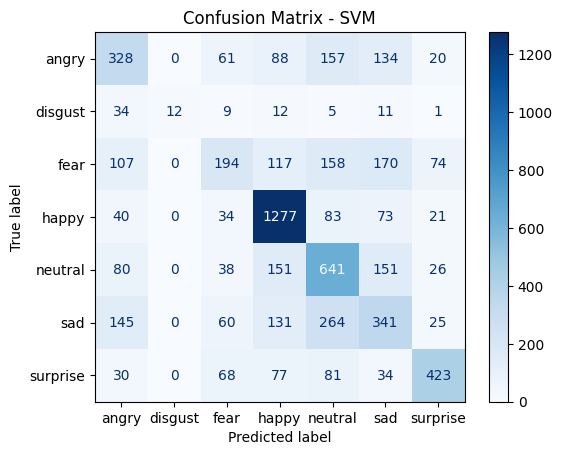

In [26]:
print(f"Training Accuracy: {train_accuracy_4SVM:.4f}")
print(f"Validation Accuracy: {val_accuracy_4SVM:.4f}")
print("\nTest Set Evaluation:")
print(f"Test Accuracy: {test_accuracy_4SVM:.4f}")
print(f"Test Precision: {precision_4SVM:.4f}")
print(f"Test Recall: {recall_4SVM:.4f}")
print(f"Test F1-Score: {f1_4SVM:.4f}")

# Compute confusion matrix on the test set
cm_4SVM = confusion_matrix(y_test_4SVM, y_test_pred_4SVM)

# Easy display with sklearn
disp_4SVM = ConfusionMatrixDisplay(confusion_matrix=cm_4SVM, display_labels=class_names)
disp_4SVM.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
plt.grid(False)
plt.show()

# **CNN Model**

In [32]:
# Define improved CNN model
model = Sequential([
    Input(shape=(48, 48, 1)), # Input layer
    
    Conv2D(32, (3, 3), activation='relu', padding='same'), # padding='same' preserves spatial dimensions (output size = input size).
    BatchNormalization(), # Normalizes layer outputs to stabilize training and accelerate convergence.
    MaxPooling2D((2, 2)), # Downsamples the feature maps by taking the maximum value in 2×2 windows, reducing spatial dimensions by half.
    Dropout(0.2), # Randomly drops 20% of neurons to prevent overfitting.
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Flatten(), # Converts 3D feature maps to 1D for dense layers.
    Dense(256, activation='relu'), # 256-neuron hidden layer with relu activation.
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax') # Output layer with 7 neurons (for 7 classes) and softmax activation to produce probability scores.
])

# Compile model
model.compile(
    optimizer='adam', # adaptive learning rate optimizer
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Applies label smoothing (reduces overconfidence in predictions by softening true labels).
    metrics=['accuracy'] # track classification accuracy
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 982,663 (3.75 MB)

 Trainable params: 981,191 (3.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [34]:
# Callbacks

# Stops training if the model stops improving (saves time/compute) and this Prevents overfitting.
early_stopping = EarlyStopping(
    monitor='val_loss',        # Watches validation loss
    patience=10,               # Stops after 10 epochs without improvement
    restore_best_weights=True  # Keeps the best model weights
)

# Saves the model whenever val_accuracy hits a new high.
checkpoint = ModelCheckpoint(
    'best_model.keras',       # Saves to this file
    monitor='val_accuracy',   # Tracks validation accuracy
    save_best_only=True       # Only saves the best model (Avoids storing worse models).
)

# Dynamically reduces the learning rate when stuck (helps escape local minima).
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Watches validation loss
    factor=0.2,          # Reduces learning rate by 20%
    patience=5,          # Waits 5 epochs before acting
    min_lr=1e-2          # Minimum allowed learning rate
)

In [29]:
# Convert integer labels to one-hot vectors encoding
y_train_aug_4CNN = to_categorical(y_train_aug_4CNN, num_classes=7)
y_val_4CNN = to_categorical(y_val_4CNN, num_classes=7)
y_test_onehot = to_categorical(y_test_4CNN, num_classes=7)

In [35]:
# Train model
history = model.fit(
    X_train_aug_4CNN, y_train_aug_4CNN, # Augmented training data
    validation_data=(X_val_4CNN, y_val_4CNN), # Validation set
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping, checkpoint, reduce_lr] # Callbacks
)

Epoch 1/200
407/407 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.2583 - loss: 2.3256 - val_accuracy: 0.1841 - val_loss: 2.9517 - learning_rate: 0.0010
Epoch 2/200
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3811 - loss: 1.7174 - val_accuracy: 0.4310 - val_loss: 1.6361 - learning_rate: 0.0010
Epoch 3/200
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4496 - loss: 1.5703 - val_accuracy: 0.4978 - val_loss: 1.4716 - learning_rate: 0.0010
Epoch 4/200
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4774 - loss: 1.5183 - val_accuracy: 0.5047 - val_loss: 1.4347 - learning_rate: 0.0010
Epoch 5/200
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5005 - loss: 1.4748 - val_accuracy: 0.5391 - val_loss: 1.3734 - learning_rate: 0.0010
Epoch 6/200
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5156 - loss: 1.4554 - val_accuracy: 0.5600 - val_loss: 1.3414 - learning_rate: 0.0010
Epoch 7/200
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5220 - loss: 

In [38]:
model.save('CNN_model.h5')

In [36]:
# Now evaluate
test_loss_4CNN, test_accuracy_4CNN = model.evaluate(X_test_4CNN, y_test_onehot)

# Evaluate model
y_pred_4CNN = np.argmax(model.predict(X_test_4CNN), axis = 1)
precision_4CNN, recall_4CNN, f1_4CNN, _ = precision_recall_fscore_support(y_test_4CNN, y_pred_4CNN, average='weighted')

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5623 - loss: 1.3246
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Training Accuracy: 0.6244
Validation Accuracy: 0.6326

Test Set Evaluation:
Test Accuracy: 0.6081
Test Precision: 0.6020
Test Recall: 0.6081
Test F1-Score: 0.5960


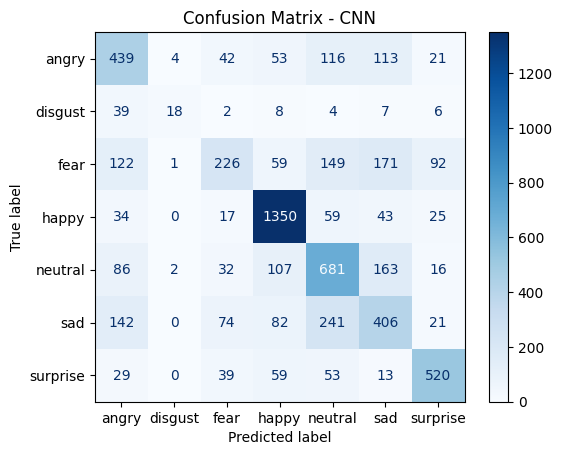

In [37]:
# Final training and validation accuracy
train_accuracy_4CNN = history.history['accuracy'][-1]
val_accuracy_4CNN = history.history['val_accuracy'][-1]

final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Training Accuracy: {train_accuracy_4CNN:.4f}")
print(f"Validation Accuracy: {val_accuracy_4CNN:.4f}")
print("\nTest Set Evaluation:")
print(f"Test Accuracy: {test_accuracy_4CNN:.4f}")
print(f"Test Precision: {precision_4CNN:.4f}")
print(f"Test Recall: {recall_4CNN:.4f}")
print(f"Test F1-Score: {f1_4CNN:.4f}")

# Compute confusion matrix on the test set
cm_4CNN = confusion_matrix(y_test_4CNN, y_pred_4CNN)

# Option 1: Easy display with sklearn
disp_4CNN = ConfusionMatrixDisplay(confusion_matrix=cm_4CNN, display_labels=class_names)
disp_4CNN.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CNN")
plt.grid(False)
plt.show()

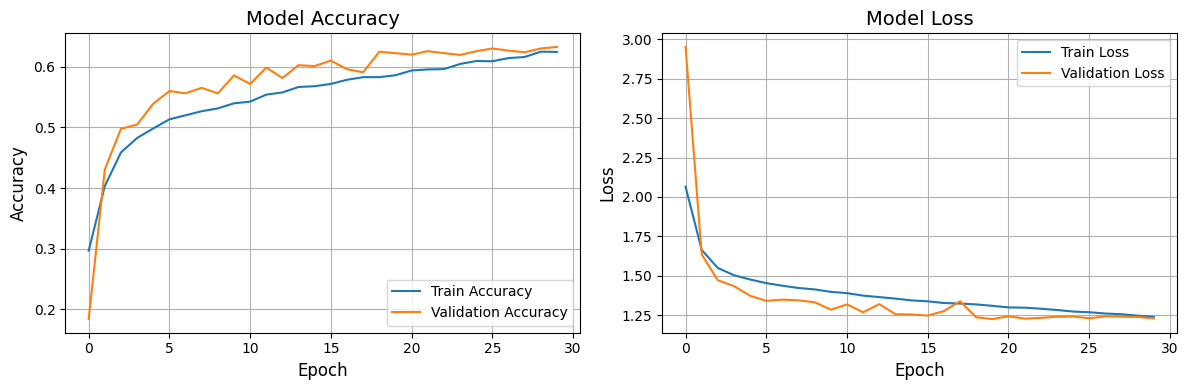

In [39]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('accuracy_loss_plots.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
print("======== Model Comparison ========")
print(f"{'Metric':<15}{'SVM':>10}{'CNN':>10}")
print(f"{'Train Acc':<15}{train_accuracy_4SVM:>10.4f}{train_accuracy_4CNN:>10.4f}")
print(f"{'Val Acc':<15}{val_accuracy_4SVM:>10.4f}{val_accuracy_4CNN:>10.4f}")
print(f"{'Test Acc':<15}{test_accuracy_4SVM:>10.4f}{test_accuracy_4CNN:>10.4f}")
print(f"{'Precision':<15}{precision_4SVM:>10.4f}{precision_4CNN:>10.4f}")
print(f"{'Recall':<15}{recall_4SVM:>10.4f}{recall_4CNN:>10.4f}")
print(f"{'F1-Score':<15}{f1_4SVM:>10.4f}{f1_4CNN:>10.4f}")

======== Model Comparison ========
Metric                SVM       CNN
Train Acc          0.6573    0.6244
Val Acc            0.5446    0.6326
Test Acc           0.5373    0.6081
Precision          0.5331    0.6020
Recall             0.5373    0.6081
F1-Score           0.5233    0.5960


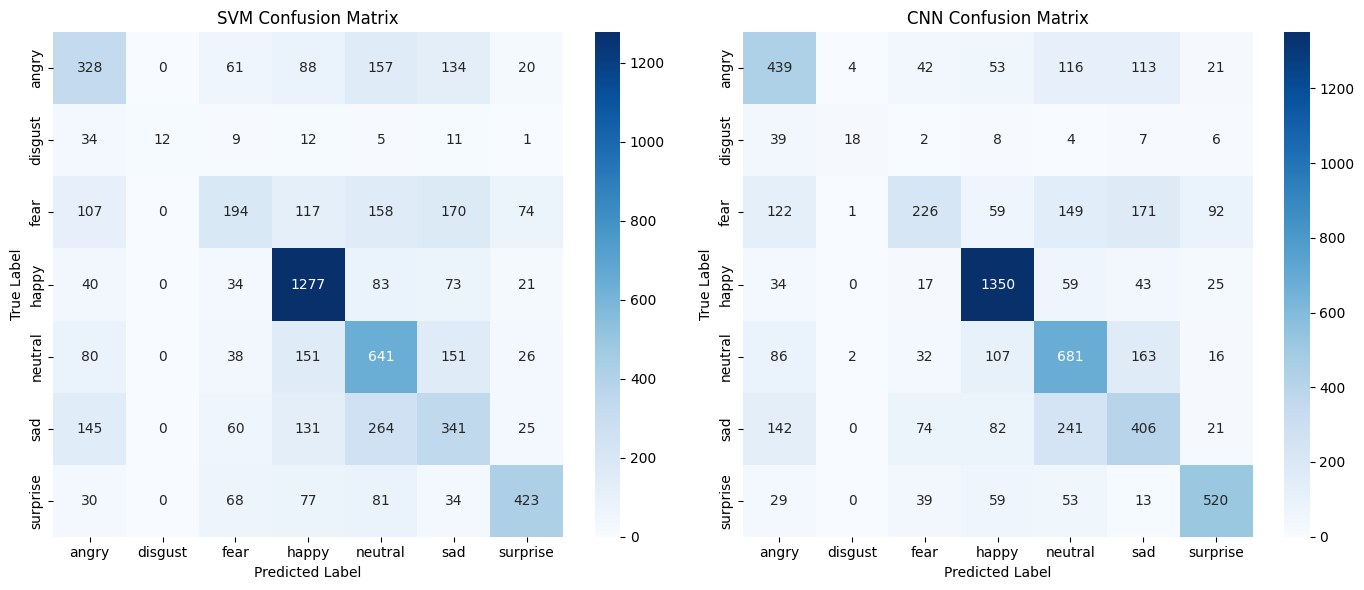

In [43]:
# Compute confusion matrices
cm_svm = confusion_matrix(y_test_4SVM, y_test_pred_4SVM)
cm_cnn = confusion_matrix(y_test_4CNN, y_pred_4CNN)

# Define class labels (adjust according to your dataset)
class_labels = class_names

# Plot both in one figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# SVM Confusion Matrix
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_labels, yticklabels=class_labels)
axes[0].set_title('SVM Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# CNN Confusion Matrix
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=class_labels, yticklabels=class_labels)
axes[1].set_title('CNN Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

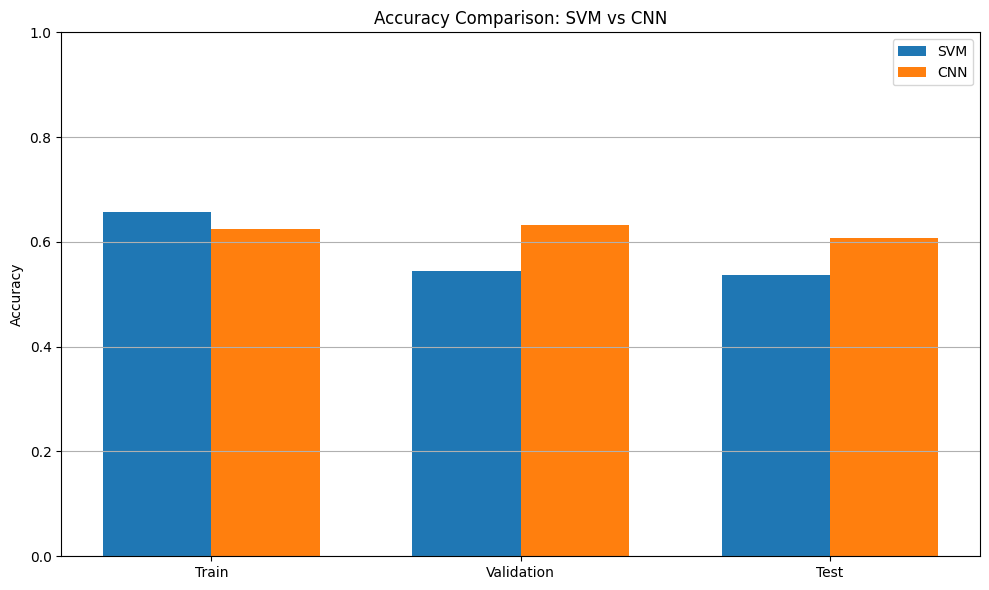

In [44]:
# Sample values – replace these with your actual computed values
svm_acc = [train_accuracy_4SVM, val_accuracy_4SVM, test_accuracy_4SVM]
cnn_acc = [train_accuracy_4CNN, val_accuracy_4CNN, test_accuracy_4CNN]
labels = ['Train', 'Validation', 'Test']

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, svm_acc, width, label='SVM')
plt.bar(x + width/2, cnn_acc, width, label='CNN')

plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: SVM vs CNN')
plt.xticks(x, labels)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

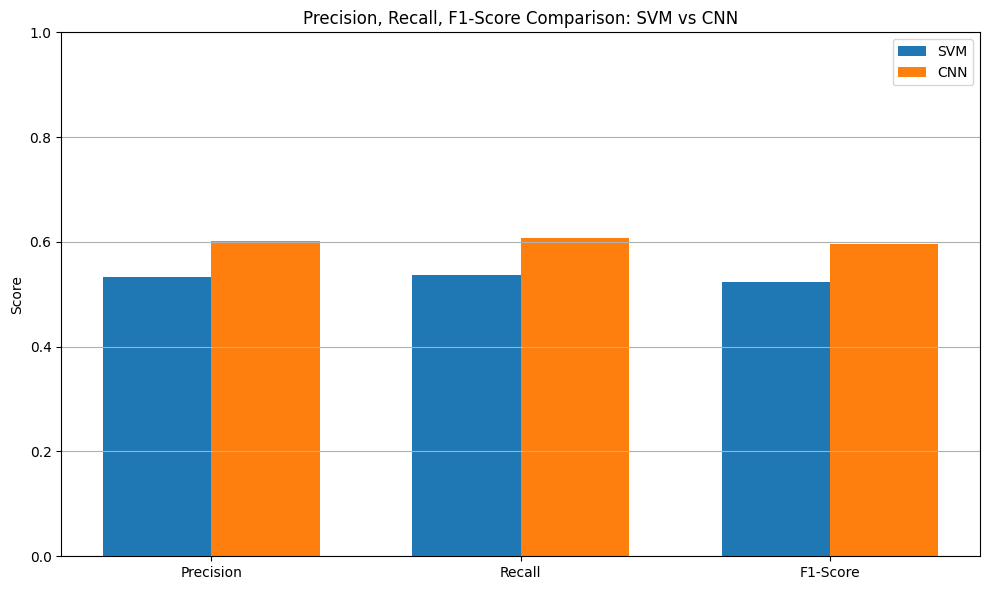

In [45]:
# Replace with your real scores
svm_metrics = [precision_4SVM, recall_4SVM, f1_4SVM]
cnn_metrics = [precision_4CNN, recall_4CNN, f1_4CNN]
metric_labels = ['Precision', 'Recall', 'F1-Score']

x = np.arange(len(metric_labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, svm_metrics, width, label='SVM')
plt.bar(x + width/2, cnn_metrics, width, label='CNN')

plt.ylabel('Score')
plt.title('Precision, Recall, F1-Score Comparison: SVM vs CNN')
plt.xticks(x, metric_labels)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Load the trained model (if not already loaded
from tensorflow import keras
model = keras.models.load_model('best_model.keras')

# **Test CNN model**

In [46]:
# Function to classify an external image and display predictions
def classify_external_image(image_path, model, class_names):
    detector = MTCNN()

    # Load the image using urllib.request
    try:
        resp = urllib.request.urlopen(image_path)
        image = np.asarray(bytearray(resp.read()), dtype="uint8")
        img = cv2.imdecode(image, cv2.IMREAD_COLOR)
    except urllib.error.URLError as e:
        print(f"Error loading image from URL: {e}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detect faces using MTCNN
    faces = detector.detect_faces(img_rgb)

    for face in faces:
        x, y, w, h = face['box']
        x, y = max(0, x), max(0, y)
        cropped_face = img[y:y+h, x:x+w]

        # Preprocess the detected face
        resized_face = cv2.resize(cropped_face, (48, 48))
        gray_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)
        processed_face = preprocess_fer2013(gray_face)
        processed_face = np.expand_dims(processed_face, axis=0)  # Create batch dimension

        # Predict emotion
        pred = model.predict(processed_face)
        class_idx = np.argmax(pred)
        class_label = class_names[class_idx]
        confidence = np.max(pred)

        # Draw bounding box and label
        cv2.rectangle(img_rgb, (x, y - 10), (x + w, y + h - 10), (0, 255, 0), 1)
        label = f"{class_label} "
        cv2.putText(img_rgb, label, (x + 5, y + h + 15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Show the result
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Predicted Emotion(s)")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


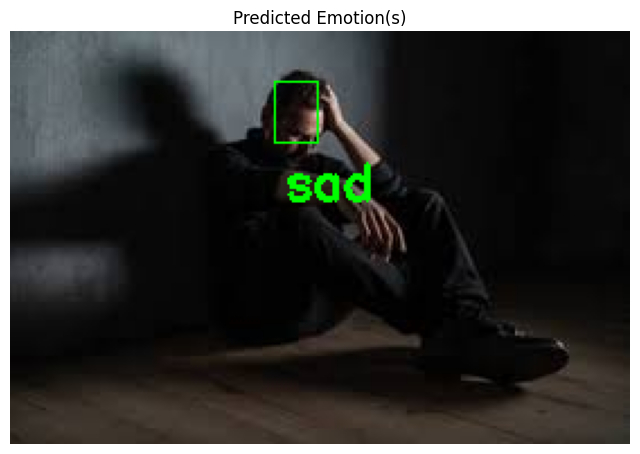

In [47]:
classify_external_image("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR117f6xB6uVIq3LmBwjIhopLSFfChlhhZ_Xg&s", model, class_names)

# **GUI with CNN model**

In [50]:
%%writefile app.py
import streamlit as st
import numpy as np
import cv2
from mtcnn import MTCNN
from PIL import Image
import tensorflow as tf
from tensorflow import keras

# Load your model and class names
model = keras.models.load_model('best_model.keras')
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Image Preprocessing
def preprocess_fer2013(img):
    
    img = img.astype(np.uint8)

    # Noise Reduction (should be done before the Contrast Adjustment)
    img = cv2.fastNlMeansDenoising( # Fast - Non-local Means Denoising
        img, None,
        h=7,   # Filter strength (5-10) (higher = more denoising) Higher values remove more noise but may lose some details
        templateWindowSize=5, # Size of the patch used to compare similarity (5x5 pixels) | Larger patches capture more structural information but are computationally expensive
        searchWindowSize=15   # Region area around each pixel where similar patches are searched (15x15 pixels) | Larger windows find more similar patches but increase computation time
    )

    # Contrast Limited Adjustment Histogram Equalization (CLAHE) -> Can help make facial features more distinguishable (improves contrast locally)
    clahe = cv2.createCLAHE(
        clipLimit=2.0, # clipLimit : Limits the amplification of contrast to prevent noise over-enhancement.
        tileGridSize=(8, 8) # Divides the image into an 8x8 grid of tiles (64 tiles total). CLAHE processes each tile independently.
    )
    img = clahe.apply(img)

    # Combines the original and blurred image to enhance edges
    blurred = cv2.GaussianBlur( # Apply Gaussian Blurring on the image
        img, # input image
        (3, 3), # kernel 3 x 3
        1.0 # Sigma of the Gaussian
    )

    # Sharpens the image by subtracting a blurred version (Unsharp Masking)
    img = cv2.addWeighted( # result = (1.2 * original) + (-0.2 * blurred) + 0
        img, # The original image
        1.2, # weight i multiply in the original one
        blurred, # the blurred image after applying Gaussian 
        -0.2, # weight i multiply in the blurred image
        0
    ) 
    
    img = img / 255.0 # Normalization -> Rescale pixel values to [0, 1]
    
    img = np.expand_dims(img, axis=-1)
    # Add channel dimension -> Shape: (48, 48, 1) For the input shape of CNN. 1 : For one channel (grayscal)
    # Shape: (48, 48, 3) For RGB image => 3 channels

    return img


# Streamlit UI
st.set_page_config(page_title="Emotion Detector", layout="centered")
st.title("😊 Facial Emotion Recognition")

uploaded_file = st.file_uploader("Upload an image with a face", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)  # <-- Now works (PIL imported)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    img = np.array(image.convert("RGB"))
    detector = MTCNN()
    faces = detector.detect_faces(img)

    if faces:
        for face in faces:
            x, y, w, h = face['box']
            x, y = max(0, x), max(0, y)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
            cropped = img[y:y+h, x:x+w]
            resized = cv2.resize(cropped, (48, 48))
            gray = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
            processed = preprocess_fer2013(gray)
            processed = np.expand_dims(processed, axis=0)
            prediction = model.predict(processed)
            predicted_class = class_names[np.argmax(prediction)]
            confidence = np.max(prediction) * 100
            label = f"{predicted_class} ({confidence:.2f}%)"

            cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (255, 0, 0), 1, cv2.LINE_AA)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        st.image(img_rgb, caption="Image with Detected Faces", use_column_width=True)
    else:
        st.warning("No face detected in the image.")

Overwriting app.py


In [51]:
# Terminate existing ngrok tunnels (if any)
ngrok.kill()

# Set your Ngrok auth token (replace with your actual token)
ngrok.set_auth_token("2wYJ3aEI2ieep6I5Nit4sSgNVSc_47BFKE2j2XdYgoG2FqzFm")

# Start Streamlit in the background (Kaggle allows subprocess.Popen)
streamlit_process = subprocess.Popen(
    ["streamlit", "run", "app.py", "--server.port=8501", "--server.headless=true"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)

# Wait a few seconds for Streamlit to start
time.sleep(5)

# Connect Ngrok to Streamlit's port (8501)
public_url = ngrok.connect(addr="8501", proto="http")
print(f"Your app is live at: {public_url}")

Your app is live at: NgrokTunnel: "https://eb9d-34-59-134-171.ngrok-free.app" -> "http://localhost:8501"
